In [51]:
import glob
import matplotlib.pyplot as plt
import os
import cv2
import shapely
import numpy as np
import json
import math
import geopandas as gpd
import pandas as pd
import time
from shapely import geometry

### This conversion function is only working at my datasets
This is conversion function between (longitude, latitude) and (x, y). <br>I saved this image to (512,512, 3) label mask images.

In [2]:
def lonlat2xy(lon_deg, lat_deg, zoom=18): 
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = ((lon_deg + 180.0) / 360.0 * n)
    ytile = ((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return (xtile, ytile)



def xy2lonlat(xtile, ytile, zoom=18):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lon_deg), (lat_deg)


def tile2xypixel(xpoint, ypoint, xtile, ytile):
    x = (int((xpoint - xtile) * 512))
    y = (int((ypoint - ytile) * 512))
    return x ,y

# First example - problem
This code has some error at intersected_polys.<br> At specific images, intersection function is not working.
I tested at only 1 image.

In [5]:
path_json = "/Users/ug/Desktop/dir/final.geojson"

In [6]:
with open(path_json) as json_file:
    json_file = json.load(json_file)
geom = [geometry.shape(poly['geometry']) for poly in json_file['features']]

In [7]:
buildings = []
for i in range(len(geom)):
    if geom[i].is_empty == False:
        buildings.append(geom[i])

In [8]:
polys = []
for geom in buildings:
    for g in geom:
        polys.append(g)

In [9]:
multi_poly = geometry.MultiPolygon(polys).buffer(0)

In [10]:
sat_path = "/Users/ug/Desktop/img/*.png"

In [11]:
sat_files = glob.glob(sat_path)

In [12]:
img_file = sat_files[1]
print(img_file)
img = cv2.imread(img_file)
mask = np.zeros_like(img)
if np.count_nonzero(img) == 0:
    print("There are some Errors")

zoom, xtile, ytile = img_file.replace(".png","").split("/")[-1].split("_")
zoom, xtile, ytile = int(zoom), int(xtile), int(ytile)
minlon, minlat = xy2lonlat(xtile, ytile, zoom)
maxlon, maxlat  = xy2lonlat(xtile + 1, ytile + 1, zoom)
box = geometry.box(minlon, minlat, maxlon, maxlat)

/Users/dabeeo/Desktop/seoul/new_2015/19_447244_202965.png


In [13]:
intersected_polys = multi_poly.intersection(box)

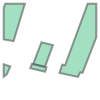

In [14]:
intersected_polys

# Second example - problem
This example used geopandas. There used gpd.overlay(how="intersection") and it was working at all imgaes.<br>
However, overaly function takes time too long.

In [16]:
path_json = "/Users/ug/Desktop/dir/final.geojson"

In [17]:
df = gpd.read_file(path_json)

In [18]:
geom = df['geometry']
geom.head()

0    GEOMETRYCOLLECTION EMPTY
1    GEOMETRYCOLLECTION EMPTY
2    GEOMETRYCOLLECTION EMPTY
3    GEOMETRYCOLLECTION EMPTY
4    GEOMETRYCOLLECTION EMPTY
Name: geometry, dtype: geometry

In [19]:
building = geom[~(geom.is_empty | geom.isna())]

/Users/dabeeo/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  """Entry point for launching an IPython kernel.


In [20]:
buildings = gpd.GeoDataFrame(building).set_geometry('geometry')['geometry']
buildings = buildings.explode()
buildings

441    0    POLYGON ((127.05994 37.58265, 127.06023 37.582...
442    0    POLYGON ((127.06013 37.58249, 127.06012 37.582...
443    0    POLYGON ((127.05985 37.58242, 127.06007 37.582...
444    0    POLYGON ((127.06033 37.58263, 127.06057 37.582...
445    0    POLYGON ((127.06033 37.58253, 127.06057 37.582...
                                  ...                        
53878  0    POLYGON ((127.04066 37.58145, 127.04067 37.581...
53879  0    POLYGON ((127.04073 37.58136, 127.04074 37.581...
53880  0    POLYGON ((127.04074 37.58145, 127.04074 37.581...
53881  0    POLYGON ((127.04078 37.58138, 127.04081 37.581...
53882  0    POLYGON ((127.04094 37.58132, 127.04095 37.581...
Name: geometry, Length: 52369, dtype: geometry

In [21]:
polys = buildings.reset_index()['geometry']
polys = gpd.GeoDataFrame(polys)
polys

,geometry
0,"POLYGON ((127.05994 37.58265, 127.06023 37.582..."
1,"POLYGON ((127.06013 37.58249, 127.06012 37.582..."
2,"POLYGON ((127.05985 37.58242, 127.06007 37.582..."
3,"POLYGON ((127.06033 37.58263, 127.06057 37.582..."
4,"POLYGON ((127.06033 37.58253, 127.06057 37.582..."
...,...
52364,"POLYGON ((127.04066 37.58145, 127.04067 37.581..."
52365,"POLYGON ((127.04073 37.58136, 127.04074 37.581..."
52366,"POLYGON ((127.04074 37.58145, 127.04074 37.581..."
52367,"POLYGON ((127.04078 37.58138, 127.04081 37.581..."


In [22]:
type(polys)

geopandas.geodataframe.GeoDataFrame

In [23]:
sat_path = "/Users/ug/Desktop/img/*.png"

In [24]:
sat_files = glob.glob(sat_path)

In [25]:
img_file = sat_files[1]
print(img_file)
img = cv2.imread(img_file)
mask = np.zeros_like(img)
if np.count_nonzero(img) == 0:
    print("There are some Errors")

zoom, xtile, ytile = img_file.replace(".png","").split("/")[-1].split("_")
zoom, xtile, ytile = int(zoom), int(xtile), int(ytile)
minlon, minlat = xy2lonlat(xtile, ytile, zoom)
maxlon, maxlat  = xy2lonlat(xtile + 1, ytile + 1, zoom)

temp_box = gpd.GeoSeries([geometry.Polygon([(minlon,minlat), (maxlon,minlat), (maxlon,maxlat), (minlon,maxlat)])])
box = gpd.GeoDataFrame({'geometry': temp_box})

/Users/dabeeo/Desktop/seoul/new_2015/19_447244_202965.png


In [26]:
start = time.time()
intersected_polys = gpd.overlay(box, polys, how="intersection")
print("time: ", time.time() - start)

time:  8.004096984863281


In [27]:
intersected_polys

,geometry
0,"POLYGON ((127.09836 37.60252, 127.09845 37.602..."
1,"POLYGON ((127.09809 37.60281, 127.09824 37.602..."
2,"POLYGON ((127.09871 37.60281, 127.09877 37.602..."
3,"POLYGON ((127.09808 37.60227, 127.09808 37.602..."
4,"POLYGON ((127.09829 37.60236, 127.09840 37.602..."


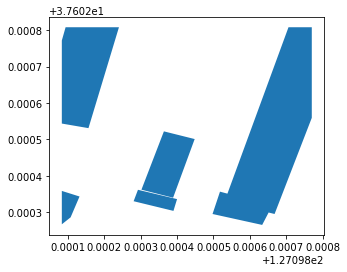

In [28]:
intersected_polys['geometry'].plot()

# Thrid example - solution
I used geopandas and rtree for spatial joins.<br> It made them efficient and took short time.

In [30]:
path_json = "/Users/ug/Desktop/dir/final.geojson"

In [31]:
df = gpd.read_file(path_json)

In [32]:
geom = df['geometry']
geom.head()

0    GEOMETRYCOLLECTION EMPTY
1    GEOMETRYCOLLECTION EMPTY
2    GEOMETRYCOLLECTION EMPTY
3    GEOMETRYCOLLECTION EMPTY
4    GEOMETRYCOLLECTION EMPTY
Name: geometry, dtype: geometry

In [33]:
building = geom[~(geom.is_empty | geom.isna())]

/Users/dabeeo/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  """Entry point for launching an IPython kernel.


In [34]:
buildings = gpd.GeoDataFrame(building).set_geometry('geometry')['geometry']
buildings = buildings.explode()
buildings

441    0    POLYGON ((127.05994 37.58265, 127.06023 37.582...
442    0    POLYGON ((127.06013 37.58249, 127.06012 37.582...
443    0    POLYGON ((127.05985 37.58242, 127.06007 37.582...
444    0    POLYGON ((127.06033 37.58263, 127.06057 37.582...
445    0    POLYGON ((127.06033 37.58253, 127.06057 37.582...
                                  ...                        
53878  0    POLYGON ((127.04066 37.58145, 127.04067 37.581...
53879  0    POLYGON ((127.04073 37.58136, 127.04074 37.581...
53880  0    POLYGON ((127.04074 37.58145, 127.04074 37.581...
53881  0    POLYGON ((127.04078 37.58138, 127.04081 37.581...
53882  0    POLYGON ((127.04094 37.58132, 127.04095 37.581...
Name: geometry, Length: 52369, dtype: geometry

In [35]:
polys = buildings.reset_index()['geometry']
polys = gpd.GeoDataFrame(polys)
polys

,geometry
0,"POLYGON ((127.05994 37.58265, 127.06023 37.582..."
1,"POLYGON ((127.06013 37.58249, 127.06012 37.582..."
2,"POLYGON ((127.05985 37.58242, 127.06007 37.582..."
3,"POLYGON ((127.06033 37.58263, 127.06057 37.582..."
4,"POLYGON ((127.06033 37.58253, 127.06057 37.582..."
...,...
52364,"POLYGON ((127.04066 37.58145, 127.04067 37.581..."
52365,"POLYGON ((127.04073 37.58136, 127.04074 37.581..."
52366,"POLYGON ((127.04074 37.58145, 127.04074 37.581..."
52367,"POLYGON ((127.04078 37.58138, 127.04081 37.581..."


In [36]:
type(polys)

geopandas.geodataframe.GeoDataFrame

In [37]:
sat_path = "/Users/ug/Desktop/img/*.png"

In [38]:
sat_files = glob.glob(sat_path)

In [48]:
img_file = sat_files[1]
print(img_file)
img = cv2.imread(img_file)
mask = np.zeros_like(img)
if np.count_nonzero(img) == 0:
    print("There are some Errors")

zoom, xtile, ytile = img_file.replace(".png","").split("/")[-1].split("_")
zoom, xtile, ytile = int(zoom), int(xtile), int(ytile)
minlon, minlat = xy2lonlat(xtile, ytile, zoom)
maxlon, maxlat  = xy2lonlat(xtile + 1, ytile + 1, zoom)

temp_box = gpd.GeoSeries([geometry.Polygon([(minlon,minlat), (maxlon,minlat), (maxlon,maxlat), (minlon,maxlat)])])
box = gpd.GeoDataFrame({'geometry': temp_box})

/Users/dabeeo/Desktop/seoul/new_2015/19_447244_202965.png


In [49]:
start = time.time()

intersected_polys = gpd.sjoin(polys, box)
intersected_polys = gpd.GeoDataFrame(intersected_polys.reset_index())

print("time: ", time.time() - start)

time:  0.3852391242980957


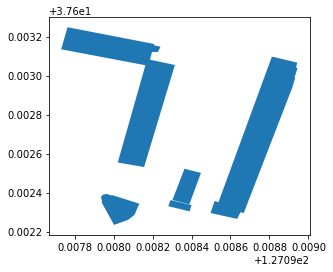

In [50]:
intersected_polys['geometry'].plot()

### Notice
It you want to save this above three intersected_polys, you can use cv2.fillPoly(). The saved results between above three intersected_polys are all the same.